I obtained a 2nd dataset which looks better than the first one. I will develop a second model and compare it to the first one to choose the better model.

### Loading primary libraries

In [60]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt              
import seaborn as sns   

## Loading the new dataset

In [61]:
df = pd.read_csv('../data/Vehicle Price.csv')
print(f'CSV file loaded succesfully!')
df.head()

CSV file loaded succesfully!


,name,description,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,2024 Jeep Wagoneer Series II,"\n \n Heated Leather Seats, Nav Sy...",Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,10.0,8-Speed Automatic,Series II,SUV,4.0,White,Global Black,Four-wheel Drive
1,2024 Jeep Grand Cherokee Laredo,Al West is committed to offering every custome...,Jeep,Grand Cherokee,2024,50170.0,OHV,6.0,Gasoline,1.0,8-Speed Automatic,Laredo,SUV,4.0,Metallic,Global Black,Four-wheel Drive
2,2024 GMC Yukon XL Denali,NaN,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8.0,Gasoline,0.0,Automatic,Denali,SUV,4.0,Summit White,Teak/Light Shale,Four-wheel Drive
3,2023 Dodge Durango Pursuit,White Knuckle Clearcoat 2023 Dodge Durango Pur...,Dodge,Durango,2023,46835.0,16V MPFI OHV,8.0,Gasoline,32.0,8-Speed Automatic,Pursuit,SUV,4.0,White Knuckle Clearcoat,Black,All-wheel Drive
4,2024 RAM 3500 Laramie,\n \n 2024 Ram 3500 Laramie Billet...,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6.0,Diesel,10.0,6-Speed Automatic,Laramie,Pickup Truck,4.0,Silver,Black,Four-wheel Drive


## Preprocess

In [62]:
print(f'The dataframe is composed by {df.shape[0]} observations & {df.shape[1]} columns.')

The dataframe is composed by 1002 observations & 17 columns.


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1002 non-null   object 
 1   description     946 non-null    object 
 2   make            1002 non-null   object 
 3   model           1002 non-null   object 
 4   year            1002 non-null   int64  
 5   price           979 non-null    float64
 6   engine          1000 non-null   object 
 7   cylinders       897 non-null    float64
 8   fuel            995 non-null    object 
 9   mileage         968 non-null    float64
 10  transmission    1000 non-null   object 
 11  trim            1001 non-null   object 
 12  body            999 non-null    object 
 13  doors           995 non-null    float64
 14  exterior_color  997 non-null    object 
 15  interior_color  964 non-null    object 
 16  drivetrain      1002 non-null   object 
dtypes: float64(4), int64(1), object(1

In [64]:
print(f'Number of null values: {df.isna().sum().sum()}')
print(f'Every null value:\n{df.isna().sum()}')

Number of null values: 283
Every null value:
name                0
description        56
make                0
model               0
year                0
price              23
engine              2
cylinders         105
fuel                7
mileage            34
transmission        2
trim                1
body                3
doors               7
exterior_color      5
interior_color     38
drivetrain          0
dtype: int64


There are some null values & some columns which are in wrong types. Preprocess will begin with correcting null values.

First, i noticed that there are some null values on the Price column. This is a essential column, so if there are no price, the observation should not exist. I will drop the observations whose price column is empty.

In [65]:
# Droping null values from the Price column.
df = df.dropna(subset=['price'])
print(f'Null values from the Price column dropped successfully!')

Null values from the Price column dropped successfully!


In [66]:
# Checking new number of null values.
print(f'Number of null values: {df.isna().sum().sum()}')
print(f'Every null value:\n{df.isna().sum()}')

Number of null values: 256
Every null value:
name                0
description        56
make                0
model               0
year                0
price               0
engine              2
cylinders         102
fuel                7
mileage            34
transmission        2
trim                1
body                3
doors               7
exterior_color      5
interior_color     37
drivetrain          0
dtype: int64


Cylinders is an important column and it has a great amount of null values. I will do some research of the column to take an action.

In [67]:
df['cylinders'].unique()

array([ 6.,  8.,  4., nan,  3.,  0.])

As we know, it is impossible for a car to have 0 cylinders, so thats a null value too.

In [68]:
print('Value Counts of the Cylinders column:')
print(df['cylinders'].value_counts())

Value Counts of the Cylinders column:
cylinders
4.0    489
6.0    272
8.0     87
3.0     27
0.0      2
Name: count, dtype: int64


The mayority of cars have 4 cylinders, and other amount has 6. First, I will start by turning the 0 values into NaN.

In [69]:
df['cylinders'] = df['cylinders'].replace(0.0, np.nan)

100 null values are too many null values too drop or impute in a single columns. For this reason, i will do a random ponderated impute.

In [70]:
# Distribution in percentage of values.
distribution_cyl = df['cylinders'].value_counts(normalize=True)
print('Distribution of Cylinders (%):')
print(distribution_cyl)

Distribution of Cylinders (%):
cylinders
4.0    0.558857
6.0    0.310857
8.0    0.099429
3.0    0.030857
Name: proportion, dtype: float64


In [71]:
# Transforming the distribution to list.
values = distribution_cyl.index.tolist()
weights = distribution_cyl.values.tolist()

# Obtaining indexs of NaN values.
nan_index = df[df['cylinders'].isna()].index

# Generating random values based on the distribution.
random_values = np.random.choice(values, size=len(nan_index), p=weights)

# Imputing the random values into the NaN indexs.
df.loc[nan_index, 'cylinders'] = random_values
print(f'Null values from the Cylinders column imputed successfully!')


Null values from the Cylinders column imputed successfully!


In [72]:
print('Value Counts of the Cylinders column:')
print(df['cylinders'].value_counts())

Value Counts of the Cylinders column:
cylinders
4.0    550
6.0    307
8.0     92
3.0     30
Name: count, dtype: int64


In [73]:
# Checking new number of null values.
print(f'Number of null values: {df.isna().sum().sum()}')
print(f'Every null value:\n{df.isna().sum()}')

Number of null values: 154
Every null value:
name               0
description       56
make               0
model              0
year               0
price              0
engine             2
cylinders          0
fuel               7
mileage           34
transmission       2
trim               1
body               3
doors              7
exterior_color     5
interior_color    37
drivetrain         0
dtype: int64


Next stop in handling null values is the description column. Description is a text free columns (object) that will not be easy for the ML library to use. It has some null values and the columns doesn't have much importance by itself. Therefore, the column will be dropped. Same happens with name. All important info of the name columns is on other columns.

In [74]:
# Droping the description column.
df = df.drop(columns=['description'])
df = df.drop(columns=['name'])
print(f'Description column dropped successfully!')
print(f'Name column dropped successfully!')

Description column dropped successfully!
Name column dropped successfully!


In [75]:
# Checking new number of null values.
print(f'Number of null values: {df.isna().sum().sum()}')
print(f'Every null value:\n{df.isna().sum()}')

Number of null values: 98
Every null value:
make               0
model              0
year               0
price              0
engine             2
cylinders          0
fuel               7
mileage           34
transmission       2
trim               1
body               3
doors              7
exterior_color     5
interior_color    37
drivetrain         0
dtype: int64


Checking values distribution for the next columns with null values.

In [76]:
print(f'Fuel unique values: {df['fuel'].unique()}')
print(f'Fuel distribution:\n{df['fuel'].value_counts()}')

Fuel unique values: ['Gasoline' 'Diesel' 'Hybrid' 'Electric' 'E85 Flex Fuel'
 'PHEV Hybrid Fuel' nan 'Diesel (B20 capable)']
Fuel distribution:
fuel
Gasoline                647
Hybrid                  135
Electric                 96
Diesel                   72
PHEV Hybrid Fuel         16
E85 Flex Fuel             5
Diesel (B20 capable)      1
Name: count, dtype: int64


Fuel columns has only 7 null values that will be imputed by mode.

In [77]:
# Imputing null values in the fuel column by mode.
df['fuel'] = df['fuel'].fillna(df['fuel'].mode()[0])
print(f'Null values from the Fuel column imputed successfully!')

Null values from the Fuel column imputed successfully!


Repeating process with engine column.

In [78]:
print(f'Number of unique values in the engine column: {df['engine'].nunique()}')
# Showing the distribution of the engine column.
print(f'Engine unique values: {df['engine'].value_counts()}')


Number of unique values in the engine column: 100
Engine unique values: engine
16V GDI DOHC Turbo                                           120
16V GDI DOHC Turbo Hybrid                                     92
c                                                             92
24V MPFI DOHC                                                 53
16V MPFI OHV                                                  46
                                                            ... 
16V MPFI DOHC Hybrid                                           1
o                                                              1
4L V-8 VVT variable valve control, regular unleaded, engi      1
DOHC, D-CVVT variable valve control, regular unleaded, en      1
8 gasoline direct injection, variable valve control, regu      1
Name: count, Length: 100, dtype: int64


In [79]:
# Imputing null values in the fuel column by mode.
df['engine'] = df['engine'].fillna(df['engine'].mode()[0])
print(f'Null values from the Engine column imputed successfully!')

Null values from the Engine column imputed successfully!


In [80]:
# Checking new number of null values.
print(f'Number of null values: {df.isna().sum().sum()}')
print(f'Every null value:\n{df.isna().sum()}')

Number of null values: 89
Every null value:
make               0
model              0
year               0
price              0
engine             0
cylinders          0
fuel               0
mileage           34
transmission       2
trim               1
body               3
doors              7
exterior_color     5
interior_color    37
drivetrain         0
dtype: int64


Checking data from mileage column.

In [81]:
# Number of unique values.
print(f'Number of unique values in the mileage column: {df['mileage'].nunique()}')
# Distribution.
print(f'Mileage unique values: {df['mileage'].value_counts()}')

Number of unique values in the mileage column: 91
Mileage unique values: mileage
5.0      113
0.0      109
10.0     103
1.0       58
6.0       50
        ... 
241.0      1
66.0       1
41.0       1
141.0      1
296.0      1
Name: count, Length: 91, dtype: int64


In [82]:
# Showing values whre mileage is null.
print(f'Null values in the Mileage column:\n{df[df['mileage'].isna()]}')

Null values in the Mileage column:
           make               model  year    price                     engine  \
27     Chrysler            Pacifica  2024  48705.0              24V MPFI DOHC   
47       Subaru             Outback  2024  44354.0         16V GDI DOHC Turbo   
63         Jeep    Grand Cherokee L  2024  51360.0              24V MPFI DOHC   
73         Jeep            Wagoneer  2024  63057.0    24V GDI DOHC Twin Turbo   
84         Jeep    Grand Cherokee L  2024  49390.0                        OHV   
87        Buick             Envista  2024  31805.0         12V GDI DOHC Turbo   
93         Ford              Ranger  2024  38740.0         16V GDI DOHC Turbo   
177     Lincoln            Nautilus  2024  64370.0         16V GDI DOHC Turbo   
217        Jeep        Wrangler 4xe  2024  50755.0  16V GDI DOHC Turbo Hybrid   
219       Honda            Prologue  2024  55800.0                          c   
225  Volkswagen                Taos  2024  25895.0         16V GDI DOHC Tu

In [83]:
df.iloc[93]

make                                  Ford
model                               Ranger
year                                  2024
price                              38740.0
engine                  16V GDI DOHC Turbo
cylinders                              4.0
fuel                              Gasoline
mileage                                NaN
transmission            10-Speed Automatic
trim                                    XL
body                          Pickup Truck
doors                                  4.0
exterior_color    Carbonized Gray Metallic
interior_color                       Ebony
drivetrain                Four-wheel Drive
Name: 93, dtype: object

After checking for some observations, the mayority of null values on this column are new cars (based on their price). Therefore, i will change Nan for 0.

In [84]:
# Turning NaN values into 0.
df['mileage'] = df['mileage'].fillna(0)
print(f'Null values from the Mileage column imputed successfully!')

Null values from the Mileage column imputed successfully!


Continuing with interior color.

In [85]:
# Unique values of interior color.
print(f'Number of unique values on Interior Color: {df['interior_color'].nunique()}')
# Distribution of interior color.
print(f'Interior Color unique values: {df['interior_color'].value_counts()}')

Number of unique values on Interior Color: 90
Interior Color unique values: interior_color
Black           497
Global Black     83
Gray             76
Jet Black        45
Ebony            38
               ... 
Caramel           1
gray              1
Dark Palazzo      1
Gray/Black        1
Navy Pier         1
Name: count, Length: 90, dtype: int64


Most of the car has black as interior color. I don't think this is one the most important columns, so i will impute the null data with mode.

In [86]:
# Imputing null values in the interior color column by mode.
df['interior_color'] = df['interior_color'].fillna(df['interior_color'].mode()[0])
print(f'Null values from the Interior Color column imputed successfully!')

Null values from the Interior Color column imputed successfully!


In [87]:
# Checking new number of null values.
print(f'Number of null values: {df.isna().sum().sum()}')
print(f'Every null value:\n{df.isna().sum()}')

Number of null values: 18
Every null value:
make              0
model             0
year              0
price             0
engine            0
cylinders         0
fuel              0
mileage           0
transmission      2
trim              1
body              3
doors             7
exterior_color    5
interior_color    0
drivetrain        0
dtype: int64


Finally, all this columns have less than 10 null values, so all of them will be imputed by mode.

In [88]:
# Imputing null values in the transmission, trim, body, doors and exterior color columns by mode.
columns_to_impute = ['transmission', 'trim', 'body', 'doors', 'exterior_color']
for column in columns_to_impute:
    df[column] = df[column].fillna(df[column].mode()[0])
    print(f'Null values from the {column} column imputed successfully!')

Null values from the transmission column imputed successfully!
Null values from the trim column imputed successfully!
Null values from the body column imputed successfully!
Null values from the doors column imputed successfully!
Null values from the exterior_color column imputed successfully!


In [89]:
print(f'Number of null values: {df.isna().sum().sum()}')

Number of null values: 0


I will finish the preprocess section changing some float types columns to int columns.

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 979 entries, 0 to 1001
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            979 non-null    object 
 1   model           979 non-null    object 
 2   year            979 non-null    int64  
 3   price           979 non-null    float64
 4   engine          979 non-null    object 
 5   cylinders       979 non-null    float64
 6   fuel            979 non-null    object 
 7   mileage         979 non-null    float64
 8   transmission    979 non-null    object 
 9   trim            979 non-null    object 
 10  body            979 non-null    object 
 11  doors           979 non-null    float64
 12  exterior_color  979 non-null    object 
 13  interior_color  979 non-null    object 
 14  drivetrain      979 non-null    object 
dtypes: float64(4), int64(1), object(10)
memory usage: 154.7+ KB


In [91]:
# Selecting float columns to convert to int.
float_columns = ['cylinders','mileage','doors']
# Converting float columns to int.
for col in float_columns:
    df[col] = df[col].astype(int)
    print(f'Column {col} converted to int successfully!')


Column cylinders converted to int successfully!
Column mileage converted to int successfully!
Column doors converted to int successfully!


## EDA

My next step is going to be to make a research of the dataset.

In [92]:
df.head()

,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6,Gasoline,10,8-Speed Automatic,Series II,SUV,4,White,Global Black,Four-wheel Drive
1,Jeep,Grand Cherokee,2024,50170.0,OHV,6,Gasoline,1,8-Speed Automatic,Laredo,SUV,4,Metallic,Global Black,Four-wheel Drive
2,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8,Gasoline,0,Automatic,Denali,SUV,4,Summit White,Teak/Light Shale,Four-wheel Drive
3,Dodge,Durango,2023,46835.0,16V MPFI OHV,8,Gasoline,32,8-Speed Automatic,Pursuit,SUV,4,White Knuckle Clearcoat,Black,All-wheel Drive
4,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6,Diesel,10,6-Speed Automatic,Laramie,Pickup Truck,4,Silver,Black,Four-wheel Drive


Starting by showing distributions of some columns.

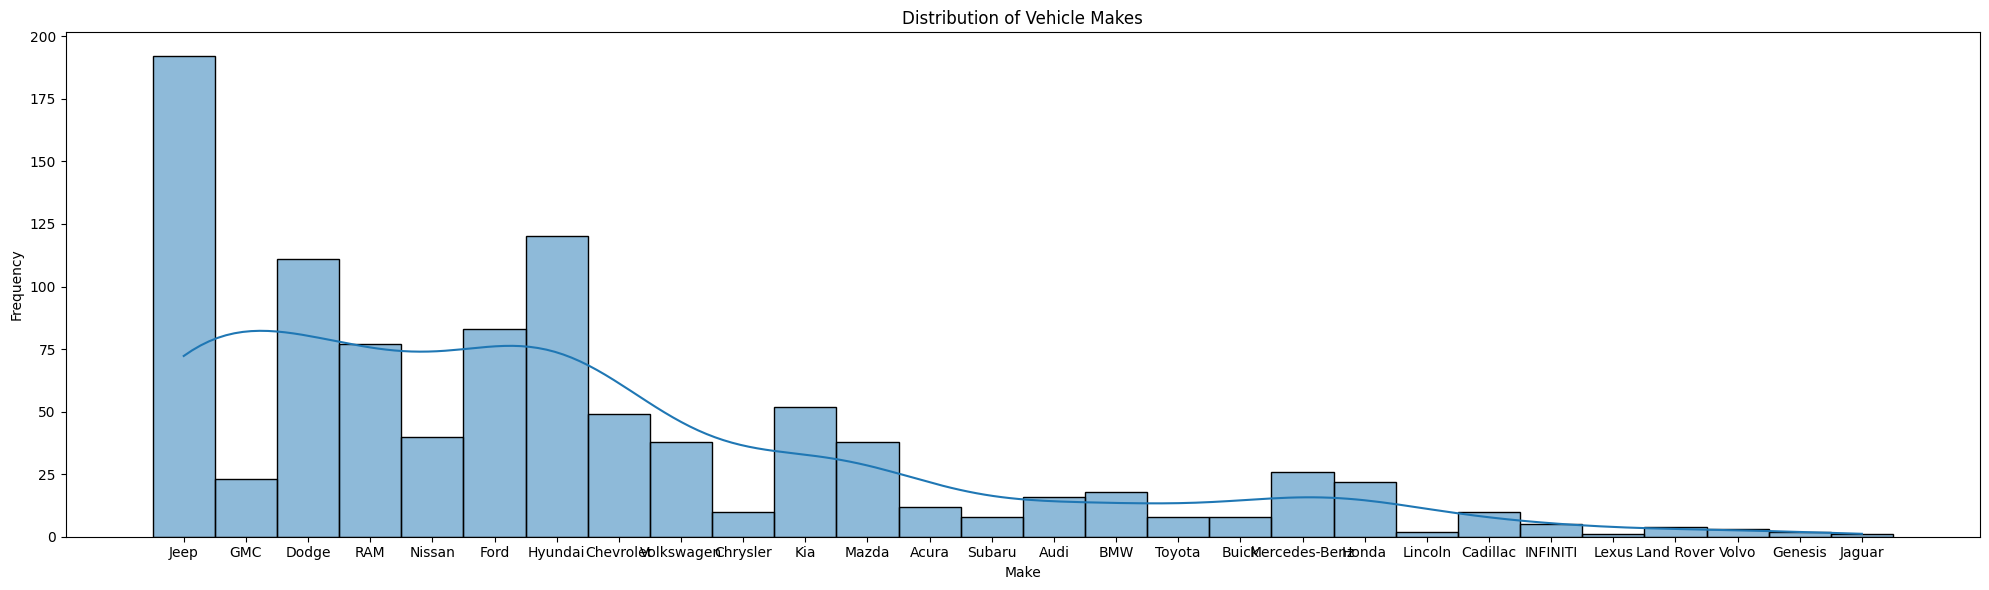

In [93]:
# Distributions of vehicle makes.
plt.figure(figsize=(20,6))
sns.histplot(df['make'], kde=True)
plt.title('Distribution of Vehicle Makes') 
plt.xlabel('Make')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


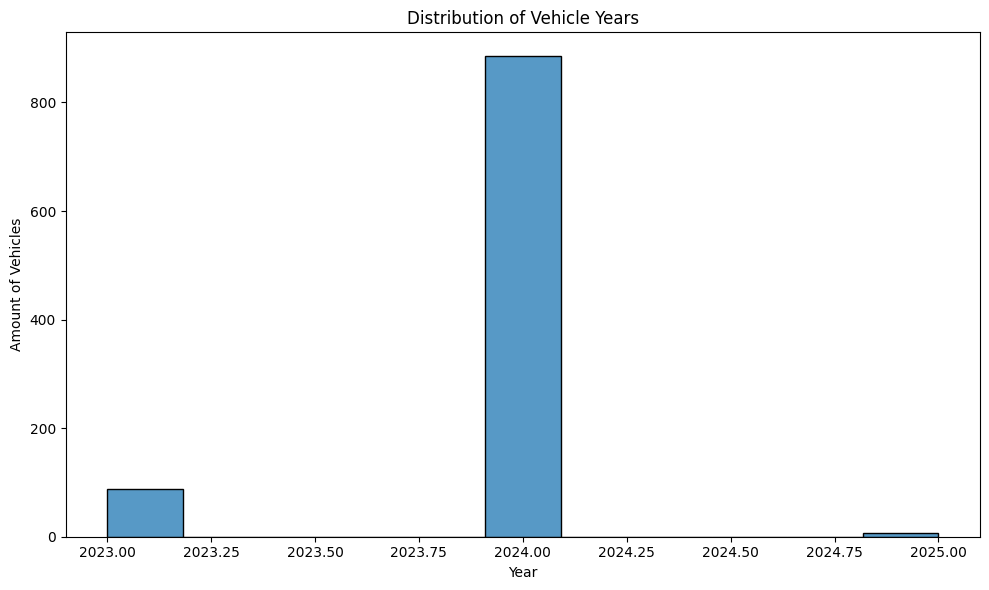

In [94]:
# Every year distribution.
plt.figure(figsize=(10,6))
sns.histplot(df['year'], kde=False)
plt.title('Distribution of Vehicle Years')
plt.xlabel('Year')
plt.ylabel('Amount of Vehicles')
plt.tight_layout()
plt.show()

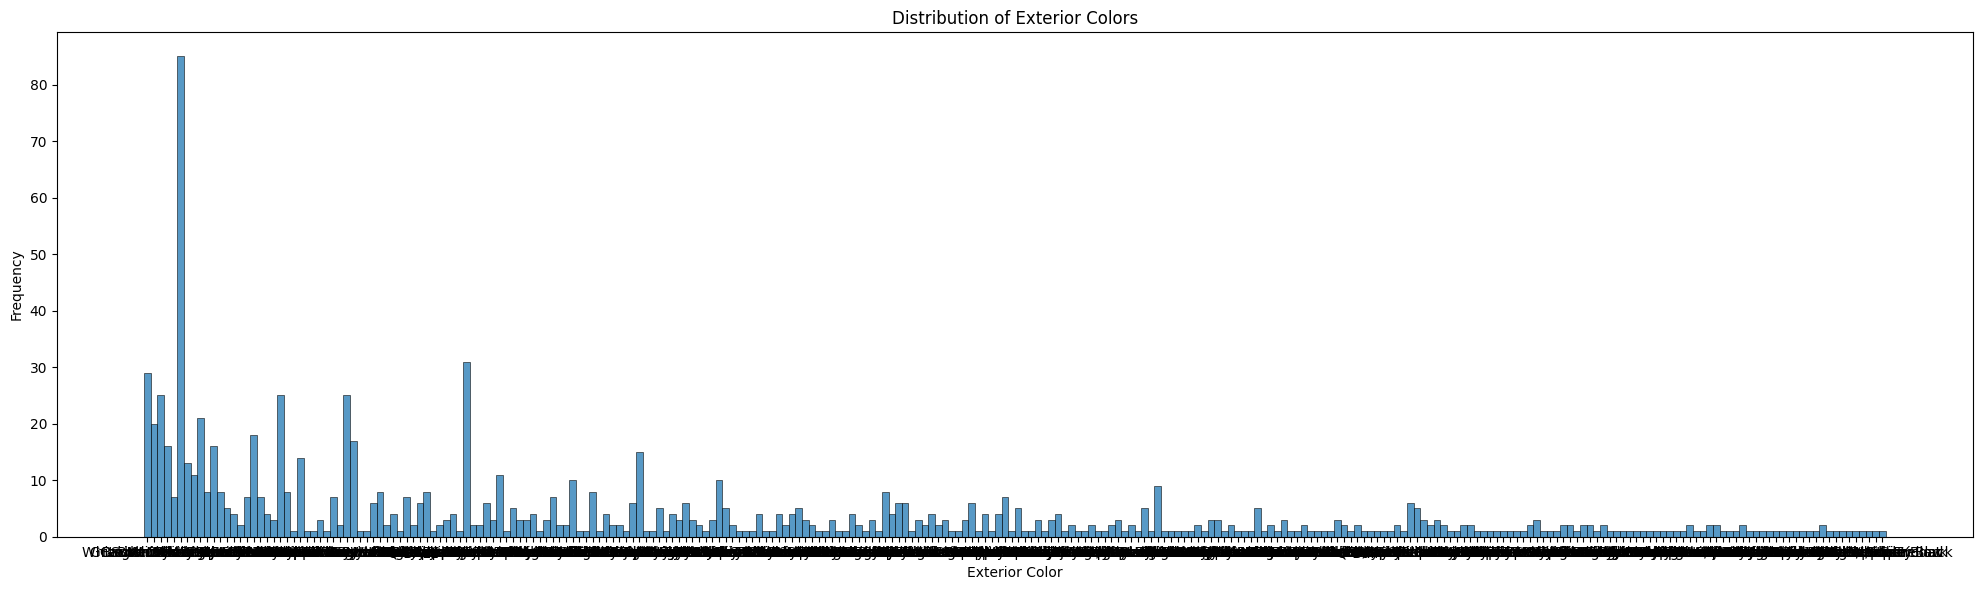

In [95]:
# Exterior colors distribution.
plt.figure(figsize=(20,6))
sns.histplot(df['exterior_color'], kde=False)
plt.title('Distribution of Exterior Colors')
plt.xlabel('Exterior Color')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Some interesting data. Doing correlations now.

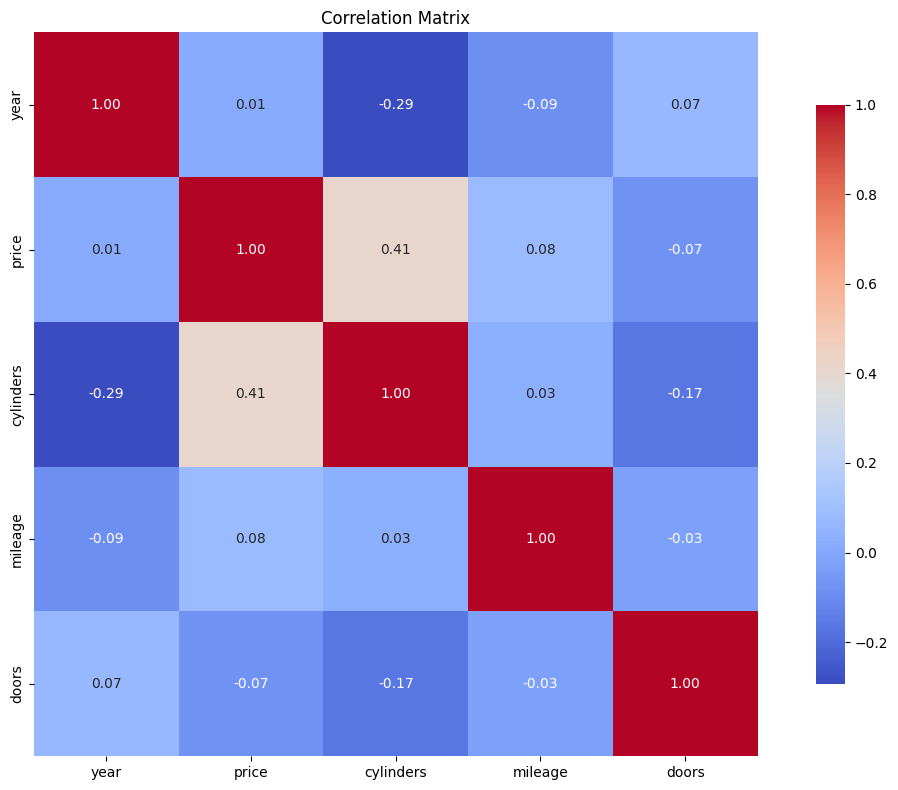

In [96]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Correlation matrix.
correlation_matrix = df[num_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Relation price/manufacturer

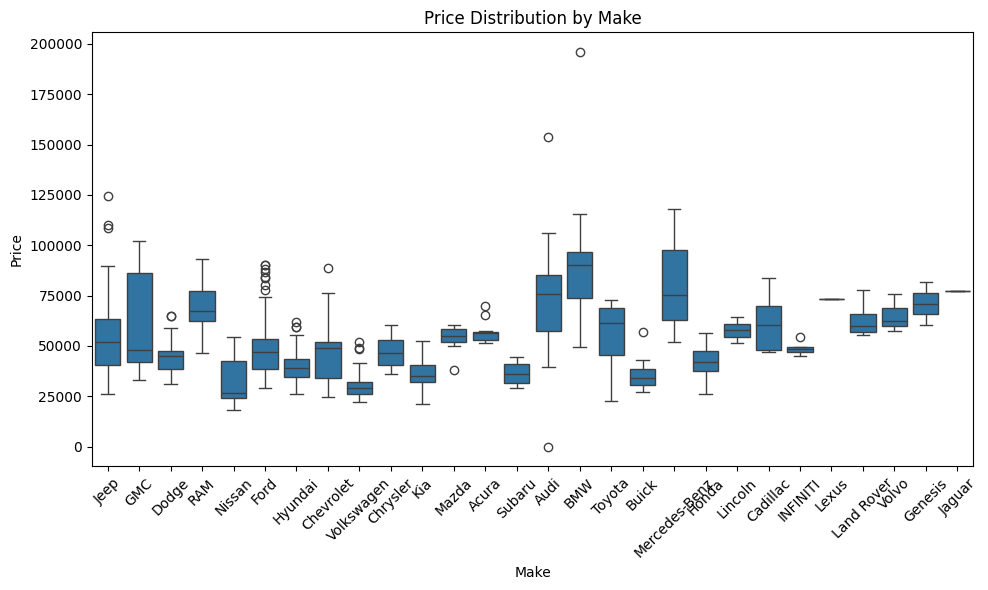

In [97]:
plt.figure(figsize=(10,6))
sns.boxplot(x='make', y='price', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution by Make')
plt.xlabel('Make')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

I can see some outliers, but mayority of vehicles makes are around the same price range (approximately).

## Model training

First, we have to codify the categorical columns. LightGBM is a decision tree based algorythm, so the categorical columns are managed by itself, and it's not necessary to codify with encoders. But i have to indicate which columns are categorical.

In [98]:
df.head()

,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6,Gasoline,10,8-Speed Automatic,Series II,SUV,4,White,Global Black,Four-wheel Drive
1,Jeep,Grand Cherokee,2024,50170.0,OHV,6,Gasoline,1,8-Speed Automatic,Laredo,SUV,4,Metallic,Global Black,Four-wheel Drive
2,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8,Gasoline,0,Automatic,Denali,SUV,4,Summit White,Teak/Light Shale,Four-wheel Drive
3,Dodge,Durango,2023,46835.0,16V MPFI OHV,8,Gasoline,32,8-Speed Automatic,Pursuit,SUV,4,White Knuckle Clearcoat,Black,All-wheel Drive
4,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6,Diesel,10,6-Speed Automatic,Laramie,Pickup Truck,4,Silver,Black,Four-wheel Drive


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 979 entries, 0 to 1001
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   make            979 non-null    object 
 1   model           979 non-null    object 
 2   year            979 non-null    int64  
 3   price           979 non-null    float64
 4   engine          979 non-null    object 
 5   cylinders       979 non-null    int64  
 6   fuel            979 non-null    object 
 7   mileage         979 non-null    int64  
 8   transmission    979 non-null    object 
 9   trim            979 non-null    object 
 10  body            979 non-null    object 
 11  doors           979 non-null    int64  
 12  exterior_color  979 non-null    object 
 13  interior_color  979 non-null    object 
 14  drivetrain      979 non-null    object 
dtypes: float64(1), int64(4), object(10)
memory usage: 154.7+ KB


Selecting categorical columns.

In [100]:
# Selecting categorical columns.
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f'Categorical columns: {categorical_cols}')
# Turning into categorical columns from pandas.
for col in categorical_cols:
    df[col] = df[col].astype('category')
    print(f'Column {col} converted to categorical successfully!')

Categorical columns: ['make', 'model', 'engine', 'fuel', 'transmission', 'trim', 'body', 'exterior_color', 'interior_color', 'drivetrain']
Column make converted to categorical successfully!
Column model converted to categorical successfully!
Column engine converted to categorical successfully!
Column fuel converted to categorical successfully!
Column transmission converted to categorical successfully!
Column trim converted to categorical successfully!
Column body converted to categorical successfully!
Column exterior_color converted to categorical successfully!
Column interior_color converted to categorical successfully!
Column drivetrain converted to categorical successfully!


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 979 entries, 0 to 1001
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   make            979 non-null    category
 1   model           979 non-null    category
 2   year            979 non-null    int64   
 3   price           979 non-null    float64 
 4   engine          979 non-null    category
 5   cylinders       979 non-null    int64   
 6   fuel            979 non-null    category
 7   mileage         979 non-null    int64   
 8   transmission    979 non-null    category
 9   trim            979 non-null    category
 10  body            979 non-null    category
 11  doors           979 non-null    int64   
 12  exterior_color  979 non-null    category
 13  interior_color  979 non-null    category
 14  drivetrain      979 non-null    category
dtypes: category(10), float64(1), int64(4)
memory usage: 122.7 KB


Now, i will set up the model.

In [102]:
import lightgbm as lgb       
from sklearn.model_selection import train_test_split

# Spliting the data into X & y.
X = df.drop(columns=['price'])
y = df['price']

# Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [103]:
# Setting up the categorical features.
lgbm_categorical_features = X.select_dtypes(include=['category']).columns.tolist()
print(f'Categorical features for LightGBM: {lgbm_categorical_features}')

Categorical features for LightGBM: ['make', 'model', 'engine', 'fuel', 'transmission', 'trim', 'body', 'exterior_color', 'interior_color', 'drivetrain']


In [104]:
# Creating the LightGBM dataset.
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=lgbm_categorical_features)
test_data = lgb.Dataset(X_test, y_test, categorical_feature=lgbm_categorical_features, reference=train_data)

In [105]:
# Defining model parameters.
params = {
    'objective' : 'regression_l1', # Regression with L1 loss (MAE)
    'metric': 'mae', # Mean Absolute Error as evaluation metric
    'n_estimators': 1000, # Number of boosting iterations
    'learning_rate': 0.05, # Learning rate for boosting
    'feature_fraction' : 0.8, # Fraction of features to consider at each iteration
    'bagging_fraction': 0.8, # Fraction of data to use for each iteration
    'bagging_freq': 1, # Frequency of bagging
    'verbose': -1, # Suppress verbose output
    'n_jobs': -1, # Use all available CPU cores
    'seed' : 42, # Random seed for reproducibility
    'boosting_type': 'gbdt' # Gradient Boosting Decision Tree
}

In [106]:
# Training the model. I will set early stopping to avoid overfitting.
model = lgb.train(params, train_data, valid_sets=[test_data], callbacks=[lgb.early_stopping(100, verbose=False)]) 

In [107]:
# Making predictions on the test set.-
predictions = model.predict(X_test)
predictions[:10]  # Displaying the first 10 predictions

array([34734.47508241, 49587.65275732, 63702.82352717, 38243.94306077,
       29019.73834118, 62628.90443566, 43478.49086904, 52345.27182008,
       55102.20940651, 44906.05693044])

## Model evaluation

Predicting prices is a regression problem, therefore the most common metrics are MAE (Mean Absolute Error), MSE (Mean Squared Error) & R2 (R-squared).

In [108]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculating evaluation metrics.
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, predictions)

# Displaying evaluation metrics.
print(f'Evaluation metrics of the LightGBM model:')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2): {r2:.4f}')

Evaluation metrics of the LightGBM model:
Mean Absolute Error (MAE): 5583.82
Mean Squared Error (MSE): 69793085.91
Root Mean Squared Error (RMSE): 8354.23
R-squared (R2): 0.7715


Displaying the evaluation on a chart. Predicted values vs Real values.

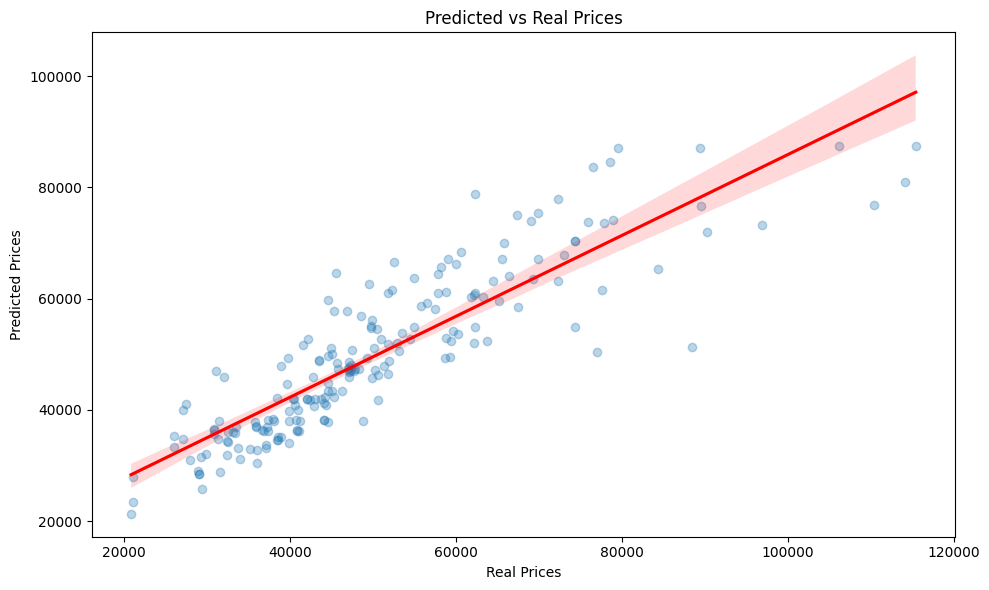

In [109]:
plt.figure(figsize=(10,6))
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.xlabel('Real Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Real Prices')
plt.tight_layout()
plt.show()

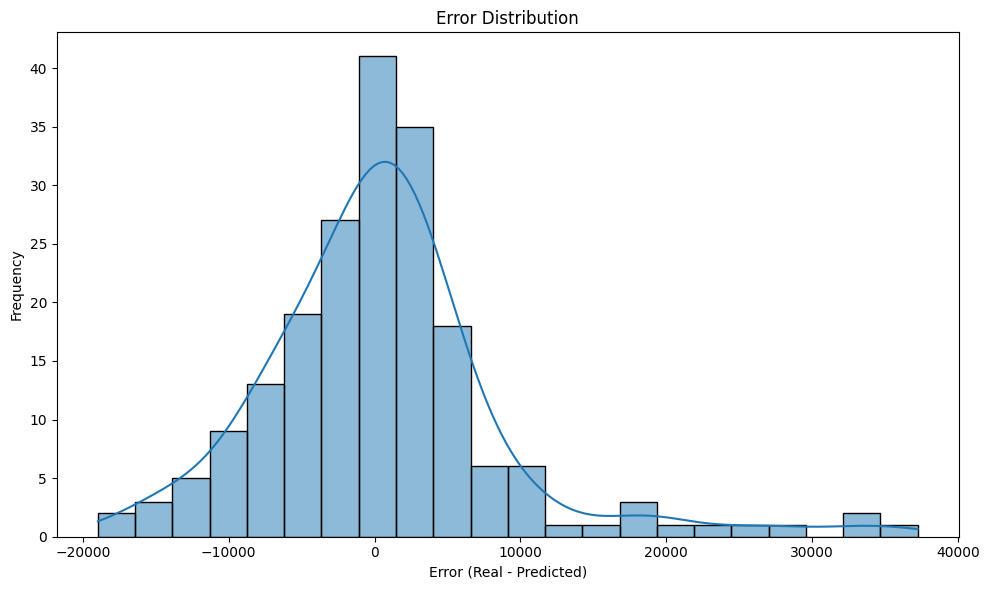

In [110]:
# Error histogram.
errors = y_test - predictions
plt.figure(figsize=(10,6))
sns.histplot(errors, kde=True)
plt.title('Error Distribution')
plt.xlabel('Error (Real - Predicted)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

As we can see, most of the predictions are right, due to the most repeated value is 0, and next are the values around him. 

MAE is around 5500€. Thats the mean error. Considering that these cars were made on the years 2023-2025 and knowing that the prices are very high, it's a good evaluation.

RMSE is little more than MAE, which is good too. 

R2 is near 0.8, which indicates that the model explains a great part of the price variability.

## Inference Function

In [111]:
def predict_car_price(car_data:dict):
    "Predicts the price of a car based on its features."
    "The data must be checked before using this function by the backend of the web app."
    """Args: 
        car_data (dict): Dictionary with car features. It must contain all the features used to train the model.
    Returns:
        float: Predicted price of the car.
    """
    # Step 1: Creating a DataFrame from the input dictionary.
    input_df = pd.DataFrame([car_data])
    # Checking that columns are in the same order as the training data.
    try:
        input_df = input_df[X_train.columns]
    except KeyError as e:
        raise KeyError(f"Missing column in input data: {e}")
    
    # Step 2: Replicate the minimum preprocessing steps.
    if 'cylinders' in input_df.columns:
        input_df['cylinders'] = input_df['cylinders'].replace(0.0, np.nan)
        input_df['cylinders'] = input_df['cylinders'].fillna(input_df['cylinders'].mode()[0])
        input_df['cylinders'] = input_df['cylinders'].astype(int)
    
    # Step 3: Convert categorical columns to 'category' type.
    for col in input_df.select_dtypes(include=['object']).columns:
        input_df[col] = input_df[col].astype('category')
    
    # Step 4: Predicting the price using the trained model.
    predicted_price = model.predict(input_df)
    
    return float(predicted_price[0])  # Return the first (and only) prediction as a float

Exporting the model.

In [112]:
import pickle 
# Exporting the model.
with open('../model/lgbm_model.pkl', 'wb') as f:
    pickle.dump(model, f)
    print(f'Model exported successfully to ../model/lgbm_model.pkl')

Model exported successfully to ../model/lgbm_model.pkl


Exporting preprocessing data

In [113]:
# Saving the preprocessor data.
preprocessor_data ={
    'expected_columns': X_train.columns.tolist(),
    'mode_cylinders' : df['cylinders'].mode()[0],
    'categorical_features_info' : {},
    'lgbm_categorical_features': lgbm_categorical_features,
}
for col in lgbm_categorical_features:
    if col in X_train.columns and pd.api.types.is_categorical_dtype(X_train[col]):
        preprocessor_data['categorical_features_info'][col] = list(X_train[col].cat.categories)

# Exporting the preprocessor data.
with open('../model/preprocessor_data.pkl', 'wb') as f:
    pickle.dump(preprocessor_data, f)
    print(f'Preprocessor data exported successfully to ../model/preprocessor_data.pkl')

Preprocessor data exported successfully to ../model/preprocessor_data.pkl


F:\Temp\ipykernel_20296\2119493216.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if col in X_train.columns and pd.api.types.is_categorical_dtype(X_train[col]):


In [114]:
# Saving the preprocessor data.
preprocessor_data ={
    'expected_columns': X_train.columns.tolist(),
    'mode_cylinders' : df['cylinders'].mode()[0],
    'categorical_features_info' : {},
    'lgbm_categorical_features': lgbm_categorical_features,
}
for col in lgbm_categorical_features:
    if col in X_train.columns and pd.api.types.is_categorical_dtype(X_train[col]):
        preprocessor_data['categorical_features_info'][col] = list(X_train[col].cat.categories)

# Exporting the preprocessor data.
with open('../model/preprocessor_data.pkl', 'wb') as f:
    pickle.dump(preprocessor_data, f)
    print(f'Preprocessor data exported successfully to ../model/preprocessor_data.pkl')

Preprocessor data exported successfully to ../model/preprocessor_data.pkl


F:\Temp\ipykernel_20296\2119493216.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if col in X_train.columns and pd.api.types.is_categorical_dtype(X_train[col]):
